In [2]:
def convert_bbox_to_absolute(bbox, image_width, image_height):
    """
    Convert bbox to absolute pixel coordinates.
    Accepts either relative ([0,1]) or already-absolute coordinates.
    Also clamps to the image bounds and fixes coordinate ordering.
    
    Args:
        bbox (list): [x_min, y_min, x_max, y_max] in relative or absolute coords
        image_width (int): Image width in pixels
        image_height (int): Image height in pixels
    
    Returns:
        list | None: [x_min, y_min, x_max, y_max] in absolute pixel coordinates or None if invalid
    """
    if bbox is None or len(bbox) != 4:
        return None

    x_min, y_min, x_max, y_max = bbox

    # If any coordinate is > 1, assume it's already absolute
    if max(x_min, y_min, x_max, y_max) > 1.0:
        abs_x_min, abs_y_min, abs_x_max, abs_y_max = int(x_min), int(y_min), int(x_max), int(y_max)
    else:
        abs_x_min = int(x_min * image_width)
        abs_y_min = int(y_min * image_height)
        abs_x_max = int(x_max * image_width)
        abs_y_max = int(y_max * image_height)

    # Fix ordering if needed
    x0, x1 = sorted((abs_x_min, abs_x_max))
    y0, y1 = sorted((abs_y_min, abs_y_max))

    # Clamp to image bounds
    x0 = max(0, min(x0, image_width - 1))
    x1 = max(0, min(x1, image_width - 1))
    y0 = max(0, min(y0, image_height - 1))
    y1 = max(0, min(y1, image_height - 1))

    # Degenerate check
    if x1 <= x0 or y1 <= y0:
        return None

    return [x0, y0, x1, y1]


In [3]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import os
from compute_overall_metrics import compute_overall_metrics

# Load the pre-computed benchmark results
results = compute_overall_metrics(
    ground_truth_dir="/Volumes/MyDataDrive/thesis/code-2/new-data/IIT-CDIP/test/labels/",
    predictions_dir="/Volumes/MyDataDrive/thesis/code-2/src/weak-labels-algo/Qwen3-30B-A3B/",
    verbose=False
)


# results = compute_overall_metrics(
#     ground_truth_dir="/Volumes/MyDataDrive/thesis/code-2/new-data/ad-buy-forms/test/labels/",
#     predictions_dir="/Volumes/MyDataDrive/thesis/code-2/new-data/ad-buy-forms/test/labels/",
#     verbose=True
# )

# Get the pre-computed results DataFrame
results_df = results['results_df']


In [4]:
print(results)

{'overall': {'precision': 0.7945762711864407, 'recall': 0.7735973597359735, 'f1': 0.7839464882943143, 'tp': 1172, 'fp': 303, 'fn': 343, 'bbox_fails': 0, 'processed_files': 100, 'error_files': 0}, 'per_entity_type': {'Contract Number': {'precision': 0.4322033898305085, 'recall': 0.75, 'f1': 0.5483870967741936, 'tp': 51, 'fp': 67, 'fn': 17, 'bbox_fails': 0, 'ground_truth_count': 68, 'predicted_count': 118, 'unmatched_gt_info': [{'gt_value': 'DPO 9552422098', 'best_match_value': 'DPO 9552422098 55501 4542', 'text_similarity': 0.8533333333333334, 'bbox_iou': 0.1462510111380748, 'document_id': 'fgvl0222_page1.json'}, {'gt_value': 'ext. 4043', 'best_match_value': 'AC5001029858', 'text_similarity': 0.39814814814814814, 'bbox_iou': 0.0, 'document_id': 'fhnm0001_page1.json'}, {'gt_value': '55238 7384', 'best_match_value': 'DPO 459561513639', 'text_similarity': 0.4708333333333334, 'bbox_iou': 0.0, 'document_id': 'fgvg0019_page1.json'}, {'gt_value': '70071 5263', 'best_match_value': 'RJR000000004

In [223]:
# Function to draw bounding boxes on an image
def draw_bboxes_from_results(image_path, page_results):
    """
    Draw bounding boxes on an image using pre-computed results
    
    Args:
        image_path: Path to the image file
        page_results: DataFrame containing results for this page
    """
    # Load and display the image
    with Image.open(image_path) as img:
        img_width, img_height = img.size
        fig, ax = plt.subplots(1, figsize=(12, 12))
        ax.imshow(img)
        
        # Define colors for different match types
        pred_colors = {
            'match': 'green',
            'bbox_fail': 'red',
            'false_positive': 'orange',
            'false_negative': 'blue'
        }
        
        gt_colors = {
            'match': 'green',
            'bbox_fail': 'yellow',
            'false_positive': 'blue',
            'false_negative': 'purple'
        }
        
        legend_elements = []
        
        # Draw boxes for each result
        for _, row in page_results.iterrows():
            match_type = row['best_match_info']
            pred_color = pred_colors.get(match_type, 'gray')
            gt_color = gt_colors.get(match_type, 'gray')
            
            # Draw predicted box if available
            if row['pred_bbox'] is not None:
                pred_abs = convert_bbox_to_absolute(row['pred_bbox'], img_width, img_height)
                if pred_abs is not None:
                    x0, y0, x1, y1 = pred_abs
                    rect = patches.Rectangle(
                        (x0, y0), x1 - x0, y1 - y0,
                        linewidth=2,
                        edgecolor=pred_color,
                        facecolor='none',
                        linestyle='-',
                        label=f'Pred: {row["Predicted"]}'
                    )
                    ax.add_patch(rect)
                    ax.text(x0, y0 - 5, f'Pred: {row["Entity Type"]}: {row["Predicted"]}',
                            color=pred_color, fontsize=8)
                    
                    # Add to legend if not already there
                    if match_type not in [elem.get_label() for elem in legend_elements]:
                        legend_elements.append(patches.Patch(facecolor='none', edgecolor=pred_color,
                                                             label=match_type))
            
            # Draw ground truth box if available
            if row['gt_bbox'] is not None and match_type != 'match':
                gt_abs = convert_bbox_to_absolute(row['gt_bbox'], img_width, img_height)
                if gt_abs is not None:
                    x0, y0, x1, y1 = gt_abs
                    rect = patches.Rectangle(
                        (x0, y0), x1 - x0, y1 - y0,
                        linewidth=2,
                        edgecolor=gt_color,
                        facecolor='none',
                        linestyle='--',
                        label=f'GT: {row["Ground Truth"]}'
                    )
                    ax.add_patch(rect)
                    if match_type != 'false_positive':
                        ax.text(x0, y1 + 10, f'GT: {row["Ground Truth"]}',
                                color=gt_color, fontsize=8)
                    # Ensure a legend entry for Ground Truth (dashed)
                    if 'Ground Truth' not in [elem.get_label() for elem in legend_elements]:
                        legend_elements.append(patches.Patch(facecolor='none', edgecolor=gt_color, linestyle='--', label='Ground Truth'))


        # Add legend
        if legend_elements:
            ax.legend(handles=legend_elements, loc='upper right', 
                      bbox_to_anchor=(1, 1), fontsize=8)

        print("DONE DRAWING")
        ax.set_axis_off()
        plt.tight_layout()
        plt.savefig(f"/Volumes/MyDataDrive/thesis/code-2/src/eval/images/e1-bbox-error.png", dpi=300)
        from IPython.display import display
        display(fig)
        plt.close(fig)


In [7]:
all_docs = sorted(results_df['Document ID'].unique())
print(f"Total number of documents: {len(all_docs)}")
print(all_docs[0])

Total number of documents: 100
fgbf0249_page1.json


Total number of documents: 100

Document 90/99
File: fjff0148_page1.json
Total predictions: 21
Correct matches: 3
Errors: 18

Breakdown by match type:
best_match_info
false_positive    9
false_negative    9
match             3
Name: count, dtype: int64

Detailed breakdown of non-matches:

FALSE_POSITIVE:
Entity Type: Phone Number
Predicted: '205-591-7171'
Ground Truth: ''
Text Similarity: 0.000
Bbox IoU: 0.000
GT Bbox: None
Pred Bbox: [1697, 1179, 2011, 1216]
Confidence: 1.000
--------------------------------------------------

FALSE_NEGATIVE:
Entity Type: Phone Number
Predicted: ''
Ground Truth: '205-591-7171'
Text Similarity: 1.000
Bbox IoU: 0.334
GT Bbox: [1719, 1170, 2105, 1253]
Pred Bbox: None
Confidence: 0.000
--------------------------------------------------

FALSE_POSITIVE:
Entity Type: Contract Number
Predicted: 'T151250797'
Ground Truth: ''
Text Similarity: 0.000
Bbox IoU: 0.000
GT Bbox: None
Pred Bbox: [2219, 3057, 2482, 3113]
Confidence: 0.989
-----------------------------

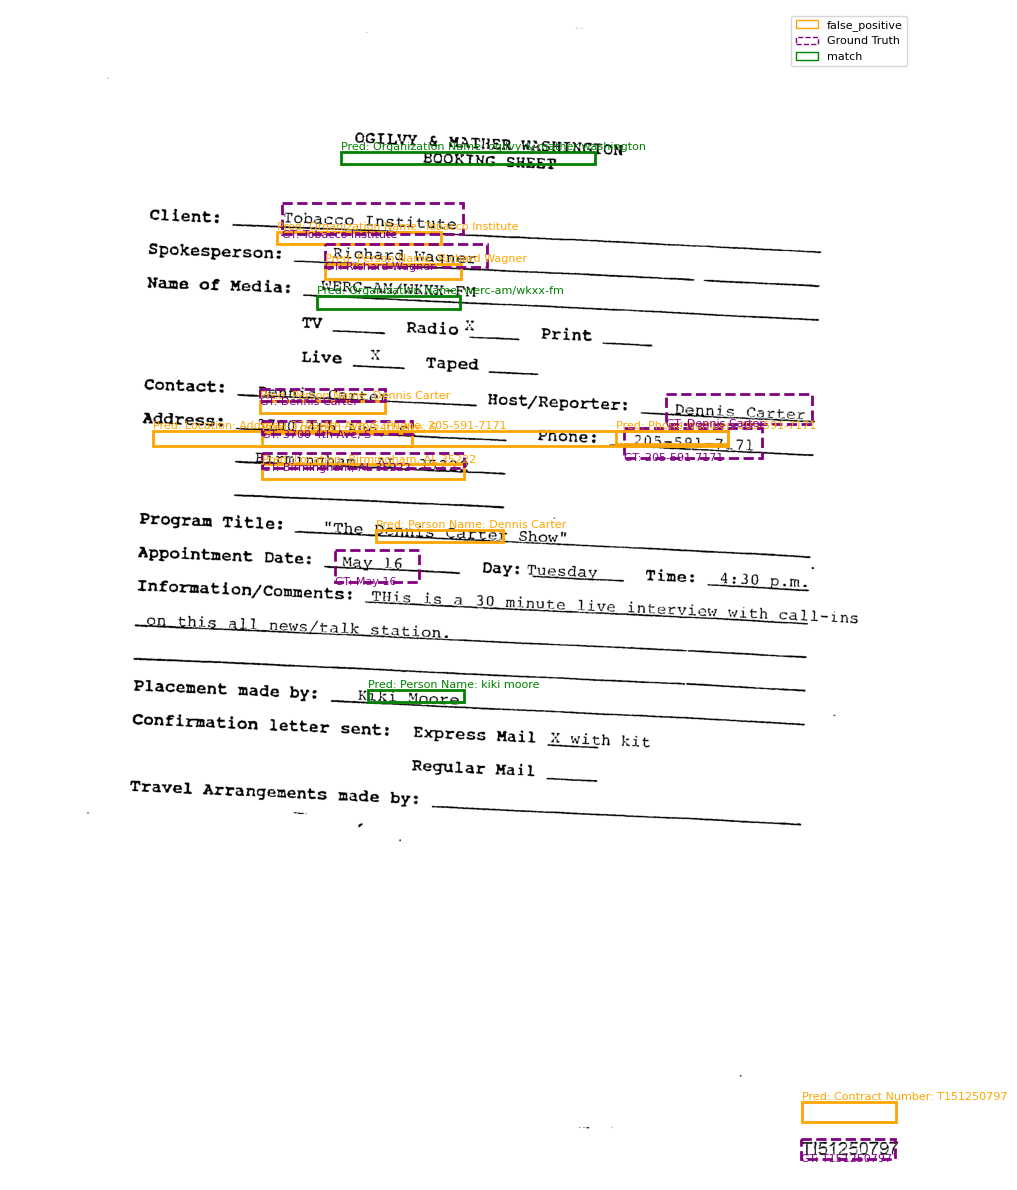

In [224]:
# Get sorted list of unique document IDs
all_docs = sorted(results_df['Document ID'].unique())
print(f"Total number of documents: {len(all_docs)}")

# Function to display results for a given index
def show_results(idx):
    if idx < 0 or idx >= len(all_docs):
        print(f"Error: Index must be between 0 and {len(all_docs)-1}")
        return
        
    page_id = all_docs[idx]
    page_results = results_df[results_df['Document ID'] == page_id].copy()

    print(f"\nDocument {idx}/{len(all_docs)-1}")
    print(f"File: {page_id}")
    print(f"Total predictions: {len(page_results)}")

    # Count matches based on best_match_info
    matches = page_results[page_results['best_match_info'] == 'match']
    errors = page_results[page_results['best_match_info'] != 'match']
    print(f"Correct matches: {len(matches)}")
    print(f"Errors: {len(errors)}")

    # Group by match type
    match_type_counts = page_results['best_match_info'].value_counts()
    print("\nBreakdown by match type:")
    print(match_type_counts)
    
    # Display detailed information for non-matching entries
    print("\nDetailed breakdown of non-matches:")
    non_matches = page_results[page_results['best_match_info'] != 'match']
    for idx, row in non_matches.iterrows():
        print(f"\n{row['best_match_info'].upper()}:")
        print(f"Entity Type: {row['Entity Type']}")
        print(f"Predicted: '{row['Predicted']}'")
        print(f"Ground Truth: '{row['Ground Truth']}'")
        print(f"Text Similarity: {row['text_similarity']:.3f}")
        print(f"Bbox IoU: {row['bbox_iou']:.3f}")
        print(f"GT Bbox: {row['gt_bbox']}")
        print(f"Pred Bbox: {row['pred_bbox']}")
        if 'Probability' in row:
            print(f"Confidence: {row['Probability']:.3f}")
        print("-" * 50)

    # Draw the boxes
    image_path = f"/Volumes/MyDataDrive/thesis/code-2/new-data/IIT-CDIP/test/images/{page_id.replace('.json', '.png')}"
    if os.path.exists(image_path):
        draw_bboxes_from_results(image_path, page_results)
    else:
        print(f"\nImage file not found: {image_path}")
        print("Please provide the correct path to your image files")

#show_results(i)
# Example: Show first document (index 0)
show_results(90)

# To view next/previous documents, just call:
# show_results(1)  # next document
# show_results(2)  # third document
# etc.


In [ ]:
# Let's examine the DataFrame structure
print("DataFrame columns:")
print(results_df.columns.tolist())

print("\nSample row:")
print(results_df.iloc[0])


In [ ]:
import os
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
from compute_overall_metrics import compute_overall_metrics
from benchmark import match_entities, bb_intersection_over_union

# First get the overall metrics and results
results = compute_overall_metrics(
    ground_truth_dir="/Volumes/MyDataDrive/thesis/code-2/data/test/labels/",
    predictions_dir="/Volumes/MyDataDrive/thesis/code-2/src/weak-labels-algo/Qwen3-30B-A3B-new-prompts-1/",
    verbose=True
)

def find_best_bbox_match(target_bbox, candidates):
    """
    Find the best matching bbox from candidates based on IoU.
    
    Args:
        target_bbox: The reference bounding box
        candidates: List of dictionaries containing 'bbox' and other fields
    
    Returns:
        best_match: The best matching candidate
        best_iou: The IoU score of the best match
    """
    best_match = None
    best_iou = 0
    
    for candidate in candidates:
        iou = bb_intersection_over_union(target_bbox, candidate['bbox'])
        if iou > best_iou:
            best_iou = iou
            best_match = candidate
            
    return best_match, best_iou

def visualize_failed_matches(document_id, results_df, ground_truth_dir, predictions_dir, images_dir):
    """
    Visualize bounding boxes for failed matches in a document.
    Red boxes: Ground truth boxes that failed to match
    Blue boxes: Prediction boxes that were close in text but failed due to bbox threshold
    Green boxes: Prediction boxes that weren't matched to any ground truth (false positives)
    """
    # Load ground truth and predictions
    gt_path = os.path.join(ground_truth_dir, document_id)
    pred_path = os.path.join(predictions_dir, f"votes_{document_id}")
    image_path = os.path.join(images_dir,  "votes_"+document_id.replace('.json', '.png'))
    
    try:
        # Load the files
        with open(gt_path, 'r') as f:
            ground_truth = json.load(f)
        with open(pred_path, 'r') as f:
            predictions_raw = json.load(f)
            
        # Filter results for this document
        doc_results = results_df[results_df['Document ID'] == document_id]
        failed_matches = doc_results[
            ((doc_results['text_similarity'] >= 0.85) & (doc_results['bbox_iou'] < 0.5)) & (doc_results['annotators'] == 'ground_truth')
            
        ]

        print(failed_matches)
        
        # Load and display the image
        img = Image.open(image_path)
        fig, ax = plt.subplots(1, figsize=(20, 20))
        ax.imshow(img)
        
        # Keep track of used predictions to avoid duplicates
        used_predictions = set()
        
        # Plot each failed match
        for _, row in failed_matches.iterrows():
            if row['Ground Truth'] != "":
                # Find all ground truth entries with this value
                gt_entries = [gt for gt in ground_truth 
                            if gt['value'].lower().strip() == row['Ground Truth'].lower().strip()]
                
                if gt_entries:
                    # For each matching ground truth entry
                    for gt_entry in gt_entries:
                        gt_bbox = gt_entry['bbox']
                        
                        # Draw ground truth box in red
                        rect = patches.Rectangle(
                            (gt_bbox[0], gt_bbox[1]),
                            gt_bbox[2] - gt_bbox[0],
                            gt_bbox[3] - gt_bbox[1],
                            linewidth=2,
                            edgecolor='red',
                            facecolor='none'
                        )
                        ax.add_patch(rect)
                        # Add ground truth label
                        ax.text(gt_bbox[0], gt_bbox[1]-5, 
                               f"{row['Entity Type']}\nGT: {row['Ground Truth']}", 
                               color='red', fontsize=8, 
                               bbox=dict(facecolor='white', alpha=0.7))
                        
                        # If there was a prediction that failed due to bbox
                        if row['text_similarity'] >= 0.85:
                            # Find all matching predictions
                            pred_entries = [p for p in predictions_raw 
                                          if p['value'].lower().strip() == row['Ground Truth'].lower().strip() 
                                          and id(p) not in used_predictions]
                            
                            if pred_entries:
                                # Find the best matching prediction based on bbox
                                best_pred, best_iou = find_best_bbox_match(gt_bbox, pred_entries)
                                
                                if best_pred:
                                    used_predictions.add(id(best_pred))
                                    pred_bbox = best_pred['bbox']
                                    
                                    # Draw prediction box in blue
                                    rect = patches.Rectangle(
                                        (pred_bbox[0], pred_bbox[1]),
                                        pred_bbox[2] - pred_bbox[0],
                                        pred_bbox[3] - pred_bbox[1],
                                        linewidth=2,
                                        edgecolor='blue',
                                        facecolor='none',
                                        linestyle='--'
                                    )
                                    ax.add_patch(rect)
                                    # Add prediction label with similarity scores
                                    ax.text(pred_bbox[0], pred_bbox[3]-40,
                                           f"Pred: {best_pred['value']}\nSim: {row['text_similarity']:.2f}, IoU: {best_iou:.2f}",
                                           color='blue', fontsize=8,
                                           bbox=dict(facecolor='white', alpha=0.7))
                                    
                                    print(f"Matched GT '{row['Ground Truth']}' at {gt_bbox} with prediction at {pred_bbox} (IoU: {best_iou:.3f})")
                            else:
                                print(f"No unused predictions found for GT: {row['Ground Truth']} at {gt_bbox}")
            
            # Handle false positives (predictions without matching ground truth)
            elif row['Predicted'] != "":
                # Find the prediction entry
                pred_entries = [p for p in predictions_raw 
                              if p['value'].lower().strip() == row['Predicted'].lower().strip()
                              and id(p) not in used_predictions]
                
                for pred_entry in pred_entries:
                    used_predictions.add(id(pred_entry))
                    pred_bbox = pred_entry['bbox']
                    
                    # Draw prediction box in green
                    rect = patches.Rectangle(
                        (pred_bbox[0], pred_bbox[1]),
                        pred_bbox[2] - pred_bbox[0],
                        pred_bbox[3] - pred_bbox[1],
                        linewidth=2,
                        edgecolor='green',
                        facecolor='none',
                        linestyle=':'  # Dotted line for false positives
                    )
                    ax.add_patch(rect)
                    # Add prediction label
                    ax.text(pred_bbox[0], pred_bbox[3]-40,
                           f"False Positive\nPred: {pred_entry['value']}\nConfidence: {pred_entry.get('probability', 0):.2f}",
                           color='green', fontsize=8,
                           bbox=dict(facecolor='white', alpha=0.7))
                    
                    print(f"False Positive: '{pred_entry['value']}' at {pred_bbox}")
        
        plt.title(f"Failed Matches for Document: {document_id}\nRed: Unmatched GT, Blue: Failed due to bbox, Green: False Positives")
        plt.axis('off')
        plt.show()
        
        # Print summary for this document
        print(f"\nSummary of Failed Matches for {document_id}:")
        print("="*50)
        by_type = failed_matches.groupby('Entity Type').agg({
            'Ground Truth': lambda x: sum(x != ""),  # Count of unmatched GT
            'Predicted': lambda x: sum((x != "") & (failed_matches['Ground Truth'] == "")),  # Count of false positives
            'text_similarity': lambda x: sum(x >= 0.85),  # Count of text matches
            'bbox_iou': lambda x: sum(x < 0.5)  # Count of bbox failures
        }).rename(columns={
            'Ground Truth': 'Unmatched GT',
            'Predicted': 'False Positives',
            'text_similarity': 'Text Matches',
            'bbox_iou': 'BBox Failures'
        })
        print(by_type)
        
    except FileNotFoundError as e:
        print(f"Error: Could not find file - {e}")
    except Exception as e:
        print(f"Error: {e}")

# Get list of documents with failures
failed_docs = results['results_df'][
    ((results['results_df']['text_similarity'] >= 0.85) & (results['results_df']['bbox_iou'] < 0.5)) & (results['results_df']['annotators'] == 'ground_truth')
]['Document ID'].unique()

print(f"Found {len(failed_docs)} documents with failed matches:")
for doc in failed_docs[:10]:  # Show first 10
    print(f"- {doc}")
print("..." if len(failed_docs) > 10 else "")


In [ ]:
# Choose a document to analyze from the failed_docs list
# You can change this to any document ID from the list above
document_id = failed_docs[21] if len(failed_docs) > 0 else None

if document_id:
    # Visualize the failed matches for this document
    visualize_failed_matches(
        document_id=document_id,
        results_df=results['results_df'],
        ground_truth_dir="/Volumes/MyDataDrive/thesis/code-2/data/test/labels/",
        predictions_dir="/Volumes/MyDataDrive/thesis/code-2/src/weak-labels-algo/Qwen3-30B-A3B-new-prompts-1/",
        images_dir="/Volumes/MyDataDrive/thesis/code-2/data/test/images/"  # Adjust this path to your images directory
    )
else:
    print("No documents with failures found.")


In [ ]:
import os
import json
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
from compute_overall_metrics import compute_overall_metrics
from benchmark import match_entities, bb_intersection_over_union
import pandas as pd

# First get the overall metrics and results
results = compute_overall_metrics(
    ground_truth_dir="/Volumes/MyDataDrive/thesis/code-2/data/test/labels/",
    predictions_dir="/Volumes/MyDataDrive/thesis/code-2/src/weak-labels-algo/Qwen3-30B-A3B-new-prompts-1/",
    verbose=True
)

def find_best_bbox_match(target_bbox, candidates):
    """
    Find the best matching bbox from candidates based on IoU.
    
    Args:
        target_bbox: The reference bounding box
        candidates: List of dictionaries containing 'bbox' and other fields
    
    Returns:
        best_match: The best matching candidate
        best_iou: The IoU score of the best match
    """
    best_match = None
    best_iou = 0
    
    for candidate in candidates:
        iou = bb_intersection_over_union(target_bbox, candidate['bbox'])
        if iou > best_iou:
            best_iou = iou
            best_match = candidate
            
    return best_match, best_iou

def visualize_failed_matches(document_id, results_df, ground_truth_dir, predictions_dir, images_dir):
    """
    Visualize bounding boxes for failed matches in a document.
    Red boxes: Ground truth boxes that failed to match
    Blue boxes: Prediction boxes that were close in text but failed due to bbox threshold
    """
    # Load ground truth and predictions
    gt_path = os.path.join(ground_truth_dir, document_id)
    pred_path = os.path.join(predictions_dir, f"votes_{document_id}")
    image_path = os.path.join(images_dir, "votes_"+document_id.replace('.json', '.png'))
    
    try:
        # Load the files
        with open(gt_path, 'r') as f:
            ground_truth = json.load(f)
        with open(pred_path, 'r') as f:
            predictions_raw = json.load(f)
            
        # Filter results for this document
        doc_results = results_df[results_df['Document ID'] == document_id]
        failed_matches = doc_results[
            ((doc_results['text_similarity'] >= 0.85) & (doc_results['bbox_iou'] < 0.5)) & (doc_results['annotators'] == 'ground_truth')   # Text match but bbox fail
            # (doc_results['Ground Truth'] != "") & (doc_results['Predicted'] == "")  # Complete misses
        ]

        pd.set_option('display.max_colwidth', None)
        pd.set_option('display.width', None)
        print(failed_matches[['Document ID','Entity Type', 'Ground Truth', 'Predicted', 'bbox_iou', 'text_similarity', 'annotators', 'best_match_info']])
        
        # Load and display the image
        img = Image.open(image_path)
        fig, ax = plt.subplots(1, figsize=(20, 20))
        ax.imshow(img)
        
        # Keep track of used predictions to avoid duplicates
        used_predictions = set()
        
        # Plot each failed match
        for _, row in failed_matches.iterrows():
            if row['Ground Truth'] != "":
                # Find all ground truth entries with this value
                gt_entries = [gt for gt in ground_truth 
                            if gt['value'].lower().strip() == row['Ground Truth'].lower().strip()]
                
                if gt_entries:
                    # For each matching ground truth entry
                    for gt_entry in gt_entries:
                        gt_bbox = gt_entry['bbox']
                        
                        # Draw ground truth box in red
                        rect = patches.Rectangle(
                            (gt_bbox[0], gt_bbox[1]),
                            gt_bbox[2] - gt_bbox[0],
                            gt_bbox[3] - gt_bbox[1],
                            linewidth=2,
                            edgecolor='red',
                            facecolor='none'
                        )
                        ax.add_patch(rect)
                        # Add ground truth label
                        ax.text(gt_bbox[0], gt_bbox[1]-5, 
                               f"{row['Entity Type']}\nGT: {row['Ground Truth']}", 
                               color='red', fontsize=8, 
                               bbox=dict(facecolor='white', alpha=0.7))
                        
                        # If there was a prediction that failed due to bbox
                        if row['text_similarity'] >= 0.85:
                            # Find all matching predictions
                            pred_entries = [p for p in predictions_raw 
                                          if p['value'].lower().strip() == row['Ground Truth'].lower().strip() 
                                          and id(p) not in used_predictions]
                            
                            if pred_entries:
                                # Find the best matching prediction based on bbox
                                best_pred, best_iou = find_best_bbox_match(gt_bbox, pred_entries)
                                
                                if best_pred:
                                    used_predictions.add(id(best_pred))
                                    pred_bbox = best_pred['bbox']
                                    
                                    # Draw prediction box in blue
                                    rect = patches.Rectangle(
                                        (pred_bbox[0], pred_bbox[1]),
                                        pred_bbox[2] - pred_bbox[0],
                                        pred_bbox[3] - pred_bbox[1],
                                        linewidth=2,
                                        edgecolor='blue',
                                        facecolor='none',
                                        linestyle='--'
                                    )
                                    ax.add_patch(rect)
                                    # Add prediction label with similarity scores
                                    ax.text(pred_bbox[0], pred_bbox[3]-40,
                                           f"Pred: {best_pred['value']}\nSim: {row['text_similarity']:.2f}, IoU: {best_iou:.2f}",
                                           color='blue', fontsize=8,
                                           bbox=dict(facecolor='white', alpha=0.7))
                                    
                                    print(f"Matched GT '{row['Ground Truth']}' at {gt_bbox} with prediction at {pred_bbox} (IoU: {best_iou:.3f})")
                            else:
                                print(f"No unused predictions found for GT: {row['Ground Truth']} at {gt_bbox}")
                                
        plt.title(f"Failed Matches for Document: {document_id}")
        plt.axis('off')
        plt.show()
        
        # Print summary for this document
        print(f"\nSummary of Failed Matches for {document_id}:")
        print("="*50)
        by_type = failed_matches.groupby('Entity Type').agg({
            'Ground Truth': 'count',
            'text_similarity': lambda x: sum(x >= 0.85),
            'bbox_iou': lambda x: sum(x < 0.5)
        }).rename(columns={
            'Ground Truth': 'Total Failures',
            'text_similarity': 'Text Matches',
            'bbox_iou': 'BBox Failures'
        })
        print(by_type)
        
    except FileNotFoundError as e:
        print(f"Error: Could not find file - {e}")
    except Exception as e:
        print(f"Error: {e}")

# Get list of documents with failures
failed_docs = results['results_df'][
    ((results['results_df']['text_similarity'] >= 0.85) & (results['results_df']['bbox_iou'] < 0.5))  & (results['results_df']['annotators'] == 'ground_truth') 
]['Document ID'].unique()

print(f"Found {len(failed_docs)} documents with failed matches:")
for doc in failed_docs[:10]:  # Show first 10
    print(f"- {doc}")
print("..." if len(failed_docs) > 10 else "")


In [ ]:
# Choose a document to analyze from the failed_docs list
# You can change this to any document ID from the list above
print(len(failed_docs))

for idx, d in enumerate(failed_docs):
    print(idx, d)

document_id = failed_docs[5] if len(failed_docs) > 0 else None

if document_id:
    # Visualize the failed matches for this document
    visualize_failed_matches(
        document_id=document_id,
        results_df=results['results_df'],
        ground_truth_dir="/Volumes/MyDataDrive/thesis/code-2/data/test/labels/",
        predictions_dir="/Volumes/MyDataDrive/thesis/code-2/src/weak-labels-algo/Qwen3-30B-A3B-new-prompts-1/",
        images_dir="/Volumes/MyDataDrive/thesis/code-2/data/test/images/"  # Adjust this path to your images directory
    )
else:
    print("No documents with failures found.")


In [ ]:
# Here i want to visualize the bbox for the failed gt values in that image based on the document id